<a href="https://colab.research.google.com/github/woojin716/PyTorch/blob/main/DL_day10/2_Regularization_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularization Techniques

Ref:    
* https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
* https://yceffort.kr/2019/02/13/pytorch-fashion-MNIST

본 실습에서는 FashionMNIST data를 활용하였습니다.

- 이미지 크기: 28x28 픽셀 (흑백 이미지)
- 훈련 데이터: 60,000개
- 테스트 데이터: 10,000개
- 클래스 수: 10개

      0 - T-shirt/top  
      1 - Trouser  
      2 - Pullover  
      3 - Dress  
      4 - Coat  
      5 - Sandal  
      6 - Shirt  
      7 - Sneaker  
      8 - Bag  
      9 - Ankle boot  

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

from torchvision import datasets, transforms

from torchsummary import summary

## Load Data (FashionMNIST)

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.47MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.72MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.3MB/s]


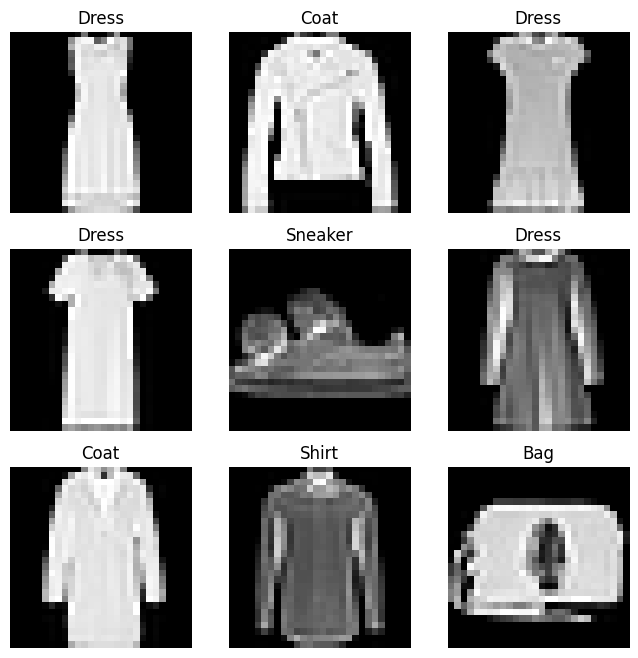

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
batch_size = 32

In [5]:
train_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True
)

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


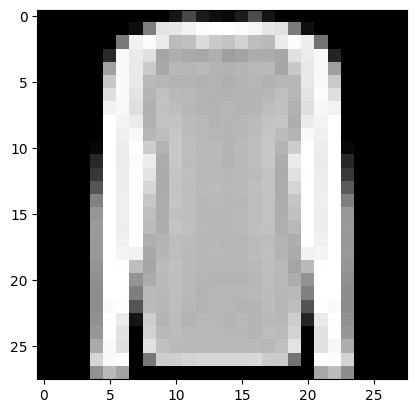

Label: 2 (labels_map[int(label)])


In [6]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label} (labels_map[int(label)])")

In [7]:
len(training_data)

60000

In [8]:
len(train_dataloader)

1875

## Build Neural Network with Regularization & Normalization Techniques

### 1. Batch Normalization (BN)

- **목적**  
  - 배치 단위로 입력 데이터를 정규화하여 학습을 안정화하고 속도를 높임  
  - 내부 공변량 변화(Internal Covariate Shift)를 줄여 모델의 학습 성능 향상  

- **동작 방식**  
  1. 미니배치(배치 크기: `N`)에서 각 특성(feature)에 대해 평균(𝜇)과 분산(𝜎²) 계산  
  2. 평균과 분산을 이용해 정규화 수행  
  3. 학습 가능한 스케일(γ)과 시프트(β) 파라미터를 적용하여 최종 변환  

-
$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
, \quad
y_i = \gamma \hat{x}_i + \beta
$

- **특징**
  - 배치 크기에 따라 평균과 분산이 달라짐 (배치 크기가 작을 경우 불안정)  
  - 주로 CNN(합성곱 신경망)에서 사용됨  

---

### (참고) Layer Normalization (LN)

- **목적**  
  - 배치 크기에 의존하지 않고, 샘플 단위로 정규화를 수행하여 안정적인 학습을 유도  
  - RNN과 같이 배치 크기가 변하는 경우에도 효과적  

- **동작 방식**  
  1. 각 샘플(인스턴스)에서 모든 특성(feature)에 대해 평균(𝜇)과 분산(𝜎²) 계산  
  2. 평균과 분산을 이용해 정규화 수행  
  3. 학습 가능한 스케일(γ)과 시프트(β) 파라미터를 적용하여 최종 변환  

- **특징**
  - 배치 크기와 관계없이 동작 가능  
  - 주로 RNN(순환 신경망)과 같은 시퀀스 모델에서 사용됨  

---

### 3. Dropout

- **목적**  
  - 뉴런을 랜덤하게 제거(비활성화)하여 과적합(overfitting)을 방지  

- **동작 방식**  
  1. 학습 중 무작위로 일부 뉴런을 확률 `p`에 따라 0으로 설정 (비활성화)  
  2. 테스트 시에는 모든 뉴런을 사용하지만, 학습 시 비활성화 확률을 고려하여 스케일링  

- **특징**
  - Fully Connected Layer에서 자주 사용됨  
  - 과적합 방지에 효과적  

---

## Summary

| 기법 | 목적 | 정규화 기준 | 주로 사용되는 곳 |
|------|------|-----------|----------------|
| **Batch Normalization** | 학습 안정화, 속도 향상 | 배치별 정규화 | CNN, 딥러닝 모델 |
| **Layer Normalization** | 배치 크기와 무관하게 정규화 | 샘플별 정규화 | RNN, Transformer |
| **Dropout** | 과적합 방지 | 뉴런 랜덤 비활성화 | Fully Connected Layer |

---

Prominent Techniques
* Batch Normalization: **Internal Covariance Shift** 방지
* Dropout: **Overfitting** 방지

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 2**8)
        self.fc2 = nn.Linear(2**8, 2**6)
        self.fc3 = nn.Linear(2**6, 2**5)
        self.fc4 = nn.Linear(2**5, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.softmax(x, dim=1)
        return x

In [10]:
class NetBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 2**8)
        self.bn1 = nn.BatchNorm1d(2**8)
        self.fc2 = nn.Linear(2**8, 2**6)
        self.bn2 = nn.BatchNorm1d(2**6)
        self.fc3 = nn.Linear(2**6, 2**5)
        self.fc4 = nn.Linear(2**5, 10)

    def forward(self, x):
        # same as torch.flatten(x,1)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.softmax(x, dim=1)
        return x

In [11]:
class NetDO(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 2**8)
        self.fc2 = nn.Linear(2**8, 2**6)
        self.fc3 = nn.Linear(2**6, 2**5)
        self.fc4 = nn.Linear(2**5, 10)
        self.dropout1 = nn.Dropout(p=0.8)
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, x):
        # same as x.view(x.size(0), -1)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.softmax(x, dim=1)
        return x

## Train the Network

### Select loss function, optimizer, learning rate scheduler

In [12]:
num_epochs = 20

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
net_nn = Net()
net_bn = NetBN()
net_do = NetDO()

In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
optimizer_nn = optim.Adam(
    net_nn.parameters(),
    lr=0.001,
)

In [17]:
optimizer_bn = optim.Adam(
    net_bn.parameters(),
    lr=0.001,
)

In [18]:
optimizer_do = optim.Adam(
    net_do.parameters(),
    lr=0.001,
)

`torch.optim.lr_scheduler.StepLR()`: step_size마다 gamma의 비율로 learning_rate 감소

In [19]:
scheduler_nn = torch.optim.lr_scheduler.StepLR(optimizer_nn, step_size= 5, gamma=0.8)

In [20]:
scheduler_bn = torch.optim.lr_scheduler.StepLR(optimizer_bn, step_size= 5, gamma=0.8)

In [21]:
scheduler_do = torch.optim.lr_scheduler.StepLR(optimizer_do, step_size= 5, gamma=0.8)

### Define `train(net, optimizer, scheduler, path_name)` Function

In [22]:
def train(net, optimizer, scheduler, path_name):

    train_losses, test_losses = [], []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        # set train mode
        net.train()

        # training
        running_loss = 0.0

        for inputs, labels in train_dataloader:

            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = net(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        # adjust learning rate with scheduler
        scheduler.step()


        # evaluation(validation)
        test_loss = 0.0
        accuracy = 0.0

        # turn off grardients for validation
        with torch.no_grad():

            # set evaluation (test) mode
            net.eval()

            for inputs, labels in test_dataloader:

                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)

                test_loss += criterion(outputs, labels)

                # 로그 확률에 지수 적용
                ps = torch.exp(outputs)

                # topk는 k번째로 큰 숫자를 찾아내는 것
                # dim=1 는 dimension을 의미
                top_p, top_class = ps.topk(1, dim=1)


                # labels를 top_class와 똑같은 형태로 만든다음에, 얼마나 같은게 있는지 확인한다.
                equals = top_class == labels.view(*top_class.shape)


                # equals를 float으로 바꾸고 평균 정확도를 구한다.
                accuracy += torch.mean(equals.type(torch.FloatTensor))


        test_accuracy = accuracy / len(test_dataloader)

        current_train_loss = running_loss / len(train_dataloader)
        current_test_loss = test_loss / len(test_dataloader)

        train_losses.append(current_train_loss)
        test_losses.append(current_test_loss.detach().cpu().numpy())

        print(
            f"Epoch: {epoch+1} / {num_epochs}..",
            "Training Loss: {:.5f}..  ".format(current_train_loss),
            "Test Loss: {:.5f}..  ".format(current_test_loss),
            "Test Accuracy: {:.3f}".format(test_accuracy)

        )

    # save trained model
    PATH = f'./{path_name}.pth'
    torch.save(net.state_dict(), PATH)

    return train_losses, test_losses

### Näive Neural Net

In [23]:
net = net_nn
optimizer = optimizer_nn
scheduler = scheduler_nn

In [24]:
net = net.to(device)

In [25]:
summary(net, (1,28,28), batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [32, 256]         200,960
            Linear-2                   [32, 64]          16,448
            Linear-3                   [32, 32]           2,080
            Linear-4                   [32, 10]             330
Total params: 219,818
Trainable params: 219,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.09
Params size (MB): 0.84
Estimated Total Size (MB): 1.02
----------------------------------------------------------------


In [27]:
train_loss_list_nn, test_loss_list_nn = train(net=net, optimizer=optimizer, scheduler=scheduler, path_name='FMNIST_nn_naive')

Epoch: 1 / 20.. Training Loss: 1.63993..   Test Loss: 1.65316..   Test Accuracy: 0.808
Epoch: 2 / 20.. Training Loss: 1.63820..   Test Loss: 1.65693..   Test Accuracy: 0.804
Epoch: 3 / 20.. Training Loss: 1.63697..   Test Loss: 1.65149..   Test Accuracy: 0.809
Epoch: 4 / 20.. Training Loss: 1.63700..   Test Loss: 1.65756..   Test Accuracy: 0.803
Epoch: 5 / 20.. Training Loss: 1.63516..   Test Loss: 1.65497..   Test Accuracy: 0.806
Epoch: 6 / 20.. Training Loss: 1.63331..   Test Loss: 1.65033..   Test Accuracy: 0.810
Epoch: 7 / 20.. Training Loss: 1.63056..   Test Loss: 1.65239..   Test Accuracy: 0.808
Epoch: 8 / 20.. Training Loss: 1.63163..   Test Loss: 1.65076..   Test Accuracy: 0.811
Epoch: 9 / 20.. Training Loss: 1.63006..   Test Loss: 1.64673..   Test Accuracy: 0.814
Epoch: 10 / 20.. Training Loss: 1.63010..   Test Loss: 1.66003..   Test Accuracy: 0.800
Epoch: 11 / 20.. Training Loss: 1.62741..   Test Loss: 1.64615..   Test Accuracy: 0.814
Epoch: 12 / 20.. Training Loss: 1.61459..

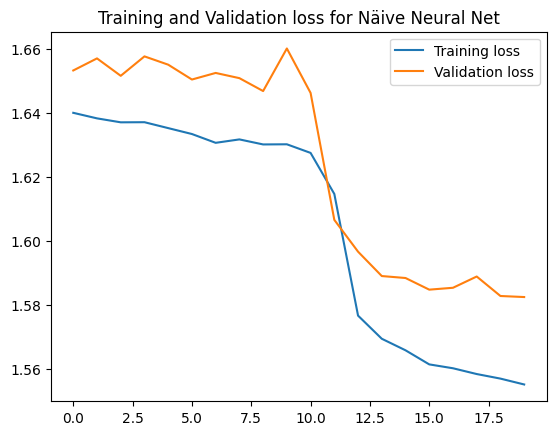

In [28]:
plt.plot(train_loss_list_nn, label='Training loss')
plt.plot(test_loss_list_nn, label='Validation loss')
plt.legend()
plt.title('Training and Validation loss for Näive Neural Net')
plt.show()

### Neural Network with Batch Normalization

In [29]:
net = net_bn
optimizer = optimizer_bn
scheduler = scheduler_bn

In [30]:
net = net.to(device)

In [31]:
summary(net, (1,28,28), batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [32, 256]         200,960
       BatchNorm1d-2                  [32, 256]             512
            Linear-3                   [32, 64]          16,448
       BatchNorm1d-4                   [32, 64]             128
            Linear-5                   [32, 32]           2,080
            Linear-6                   [32, 10]             330
Total params: 220,458
Trainable params: 220,458
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.17
Params size (MB): 0.84
Estimated Total Size (MB): 1.10
----------------------------------------------------------------


In [32]:
train_loss_list_bn, test_loss_list_bn = train(net=net, optimizer=optimizer, scheduler=scheduler, path_name='FMNIST_nn_batchnorm')

Epoch: 1 / 20.. Training Loss: 1.68022..   Test Loss: 1.62104..   Test Accuracy: 0.842
Epoch: 2 / 20.. Training Loss: 1.61819..   Test Loss: 1.61090..   Test Accuracy: 0.851
Epoch: 3 / 20.. Training Loss: 1.60524..   Test Loss: 1.60327..   Test Accuracy: 0.859
Epoch: 4 / 20.. Training Loss: 1.59966..   Test Loss: 1.60265..   Test Accuracy: 0.858
Epoch: 5 / 20.. Training Loss: 1.59320..   Test Loss: 1.60207..   Test Accuracy: 0.859
Epoch: 6 / 20.. Training Loss: 1.58543..   Test Loss: 1.59745..   Test Accuracy: 0.863
Epoch: 7 / 20.. Training Loss: 1.58152..   Test Loss: 1.59739..   Test Accuracy: 0.864
Epoch: 8 / 20.. Training Loss: 1.57936..   Test Loss: 1.59214..   Test Accuracy: 0.868
Epoch: 9 / 20.. Training Loss: 1.57626..   Test Loss: 1.59061..   Test Accuracy: 0.869
Epoch: 10 / 20.. Training Loss: 1.57516..   Test Loss: 1.60275..   Test Accuracy: 0.857
Epoch: 11 / 20.. Training Loss: 1.56828..   Test Loss: 1.58356..   Test Accuracy: 0.876
Epoch: 12 / 20.. Training Loss: 1.56630..

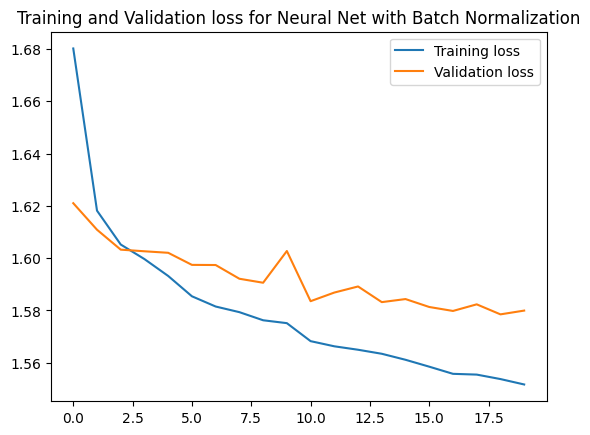

In [33]:
plt.plot(train_loss_list_bn, label='Training loss')
plt.plot(test_loss_list_bn, label='Validation loss')
plt.legend()
plt.title('Training and Validation loss for Neural Net with Batch Normalization')
plt.show()

### Neural Network with Dropout

In [34]:
net = net_do
optimizer = optimizer_do
scheduler = scheduler_do

In [35]:
net = net.to(device)

In [36]:
summary(net, (1,28,28), batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [32, 256]         200,960
           Dropout-2                  [32, 256]               0
            Linear-3                   [32, 64]          16,448
           Dropout-4                   [32, 64]               0
            Linear-5                   [32, 32]           2,080
            Linear-6                   [32, 10]             330
Total params: 219,818
Trainable params: 219,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.17
Params size (MB): 0.84
Estimated Total Size (MB): 1.10
----------------------------------------------------------------


In [37]:
train_loss_list_do, test_loss_list_do = train(net=net, optimizer=optimizer, scheduler=scheduler, path_name='FMNIST_nn_dropout')

Epoch: 1 / 20.. Training Loss: 1.86105..   Test Loss: 1.69621..   Test Accuracy: 0.765
Epoch: 2 / 20.. Training Loss: 1.74260..   Test Loss: 1.68544..   Test Accuracy: 0.773
Epoch: 3 / 20.. Training Loss: 1.72889..   Test Loss: 1.67694..   Test Accuracy: 0.782
Epoch: 4 / 20.. Training Loss: 1.71930..   Test Loss: 1.67464..   Test Accuracy: 0.786
Epoch: 5 / 20.. Training Loss: 1.71323..   Test Loss: 1.66428..   Test Accuracy: 0.796
Epoch: 6 / 20.. Training Loss: 1.70187..   Test Loss: 1.65814..   Test Accuracy: 0.804
Epoch: 7 / 20.. Training Loss: 1.69645..   Test Loss: 1.65352..   Test Accuracy: 0.808
Epoch: 8 / 20.. Training Loss: 1.69504..   Test Loss: 1.65976..   Test Accuracy: 0.802
Epoch: 9 / 20.. Training Loss: 1.69144..   Test Loss: 1.65402..   Test Accuracy: 0.807
Epoch: 10 / 20.. Training Loss: 1.68673..   Test Loss: 1.64866..   Test Accuracy: 0.811
Epoch: 11 / 20.. Training Loss: 1.68068..   Test Loss: 1.64723..   Test Accuracy: 0.813
Epoch: 12 / 20.. Training Loss: 1.67609..

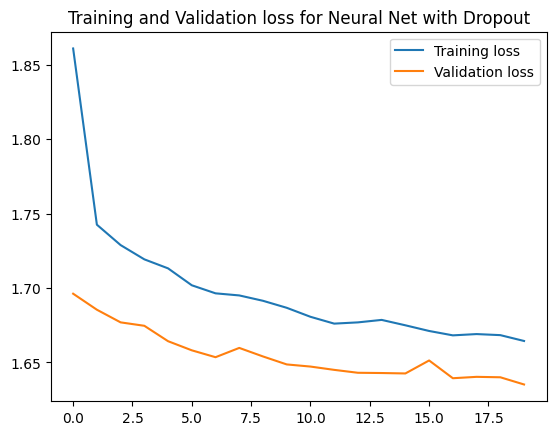

In [38]:
plt.plot(train_loss_list_do, label='Training loss')
plt.plot(test_loss_list_do, label='Validation loss')
plt.legend()
plt.title('Training and Validation loss for Neural Net with Dropout')
plt.show()

## Example data 로 세 모델의 예측결과 비교

In [62]:
import random
r = random.randint(0, len(test_data)-1)
X_single_data = test_data.data[r:r + 1].view(-1,28*28).float().to(device)
Y_single_data = test_data.targets[r:r + 1].to(device)

Output of net_nn: tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Output of net_bn: tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])
Output of net_do: tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


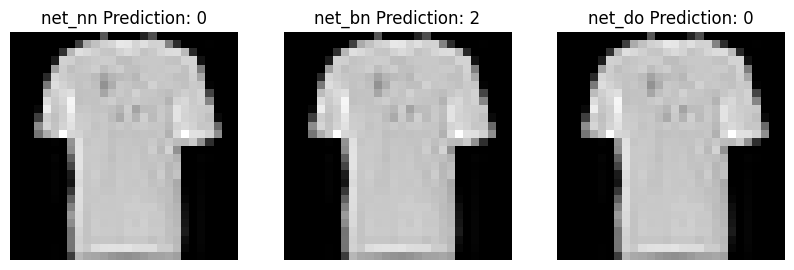

In [63]:
net_nn.to(device)
net_bn.to(device)
net_do.to(device)

# 모델 인스턴스 생성 및 저장된 가중치 로드
net_nn.load_state_dict(torch.load("FMNIST_nn_naive.pth"))
net_bn.load_state_dict(torch.load("FMNIST_nn_batchnorm.pth"))
net_do.load_state_dict(torch.load("FMNIST_nn_dropout.pth"))

# 모델을 평가 모드로 설정
net_nn.eval()
net_bn.eval()
net_do.eval()

# 각 모델의 출력 계산
output_nn = net_nn(X_single_data)
output_bn = net_bn(X_single_data)
output_do = net_do(X_single_data)

print("Output of net_nn:", output_nn.cpu().data)
print("Output of net_bn:", output_bn.cpu().data)
print("Output of net_do:", output_do.cpu().data)

# 예측 레이블 계산
pred_nn = torch.max(output_nn, 1)[1].item()
pred_bn = torch.max(output_bn, 1)[1].item()
pred_do = torch.max(output_do, 1)[1].item()

# 이미지 시각화
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].imshow(X_single_data.cpu().data.view(28, 28).numpy(), cmap='gray')
axes[0].set_title(f'net_nn Prediction: {pred_nn}')
axes[0].axis('off')

axes[1].imshow(X_single_data.cpu().data.view(28, 28).numpy(), cmap='gray')
axes[1].set_title(f'net_bn Prediction: {pred_bn}')
axes[1].axis('off')

axes[2].imshow(X_single_data.cpu().data.view(28, 28).numpy(), cmap='gray')
axes[2].set_title(f'net_do Prediction: {pred_do}')
axes[2].axis('off')

plt.show()

In [64]:
Y_single_data

tensor([0], device='cuda:0')